# Aircraft Engine RUL Prediction Using 1D Convolutional Neural Network

In [1]:
import pandas as pd
import numpy as np
#to plot the data
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
%matplotlib inline
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler #to normalize data
import os
os.chdir("/Users/tomxu/Documents/NASA-Jet-Engine-Maintenance/Data/CMaps/")
#for deep learning
import tensorflow.keras
import tensorflow.keras.backend as k
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Activation, Masking, Dropout, GlobalAveragePooling1D
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.callbacks import History
from tensorflow.keras import callbacks

Init Plugin
Init Graph Optimizer
Init Kernel


In [56]:
# based on data wrangling python notebook
def prepare_data(drop_cols = True):
    dependent_var = ['RUL']
    index_columns_names =  ["UnitNumber", "Cycle"]
    operational_settings_columns_names = ["OpSet"+str(i) for i in range(1,4)]
    sensor_measure_columns_names =["SensorMeasure"+str(i) for i in range(1,22)]
    input_file_column_names = index_columns_names + operational_settings_columns_names + sensor_measure_columns_names
    # drop all operation and linear sensor variables
    cols_to_drop = ['OpSet1', 'OpSet2', 'OpSet3', 'SensorMeasure1', 'SensorMeasure5', 'SensorMeasure6', 'SensorMeasure10',
                    'SensorMeasure14', 'SensorMeasure16', 'SensorMeasure18', 'SensorMeasure19']
    df_train = pd.read_csv('train_FD001.txt', delim_whitespace=True, names=input_file_column_names)
    rul = pd.DataFrame(df_train.groupby('UnitNumber')['Cycle'].max()).reset_index()
    rul.columns = ['UnitNumber', 'max']
    df_train = df_train.merge(rul, on=['UnitNumber'], how='left')
    df_train['RUL'] = df_train['max'] - df_train['Cycle']
    df_train.drop('max', axis=1, inplace=True)
    df_test = pd.read_csv('test_FD001.txt', delim_whitespace=True, names=input_file_column_names)
    if(drop_cols == True):
        df_train = df_train.drop(cols_to_drop, axis = 1)
        df_test = df_test.drop(cols_to_drop, axis = 1)
    y_true = pd.read_csv('RUL_FD001.txt', delim_whitespace=True, names=["RUL"])
    y_true["UnitNumber"] = y_true.index    
    return df_train, df_test, y_true

In [57]:
df_train, df_test, y_true = prepare_data(drop_cols=True)
df_train.shape, df_test.shape, y_true.shape

((20631, 16), (13096, 15), (100, 2))

In [58]:
feats = df_train.columns.drop(['UnitNumber', 'Cycle', 'RUL'])
feats

Index(['SensorMeasure2', 'SensorMeasure3', 'SensorMeasure4', 'SensorMeasure7',
       'SensorMeasure8', 'SensorMeasure9', 'SensorMeasure11',
       'SensorMeasure12', 'SensorMeasure13', 'SensorMeasure15',
       'SensorMeasure17', 'SensorMeasure20', 'SensorMeasure21'],
      dtype='object')

## Model

### Data Preprocessing

To make sure that variance of features remain in the same range, it is important to scale the features. If a feature's variance is order of magnitude more than the variance of other features, that particular feature might dominate other features in the dataset, which is not desirable.

In [59]:
min_max_scaler = MinMaxScaler(feature_range=(-1,1))
df_train[feats] = min_max_scaler.fit_transform(df_train[feats])
df_test[feats] = min_max_scaler.fit_transform(df_test[feats])

1D CNN expects an input in the shape of a numpy array of 3 dimensions and I will need to convert train and test data accordingly.

In [60]:
def gen_train(id_df, seq_length, seq_cols):
    """
        function to prepare train data into (samples, time steps, features)
        id_df = train dataframe
        seq_length = look back period
        seq_cols = feature columns
    """        
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    oneD_CNN_array=[]    
    for start, stop in zip(range(0, num_elements-seq_length+1), range(seq_length, num_elements+1)):
        oneD_CNN_array.append(data_array[start:stop, :])    
    return np.array(oneD_CNN_array)

In [61]:
def gen_target(id_df, seq_length, label):
    data_array = id_df[label].values
    num_elements = data_array.shape[0]
    return data_array[seq_length-1:num_elements+1]

In [62]:
def gen_test(id_df, seq_length, seq_cols, mask_value):
    """
        function to prepare test data into (samples, time steps, features)
        function only returns last sequence of data for every unit
        id_df = test dataframe
        seq_length = look back period
        seq_cols = feature columns
    """
    df_mask = pd.DataFrame(np.zeros((seq_length-1,id_df.shape[1])),columns=id_df.columns)
    df_mask[:] = mask_value    
    id_df1 = pd.concat([df_mask, id_df], ignore_index=True)    
    data_array = id_df1[seq_cols].values
    num_elements = data_array.shape[0]
    oneD_CNN_array=[]    
    start = num_elements-seq_length
    stop = num_elements    
    oneD_CNN_array.append(data_array[start:stop, :])
    return np.array(oneD_CNN_array)


Let's define look back period and mask_value

In [63]:
sequence_length = 30
mask_value = 0


Let's prepare data using above functions.

In [64]:
#generate train
x_train=np.concatenate(list(list(gen_train(df_train[df_train['UnitNumber']==unit], sequence_length, feats)) for unit in df_train['UnitNumber'].unique()))
print(x_train.shape)

(17731, 30, 13)


In [65]:
#generate target of train
y_train = np.concatenate(list(list(gen_target(df_train[df_train['UnitNumber']==unit], sequence_length, "RUL")) for unit in df_train['UnitNumber'].unique()))
y_train.shape

(17731,)

In [66]:
#generate test
x_test=np.concatenate(list(list(gen_test(df_test[df_test['UnitNumber']==unit], sequence_length, feats, mask_value)) for unit in df_test['UnitNumber'].unique()))
print(x_test.shape)

(100, 30, 13)


In [67]:
#true target of test 
y_test = y_true.RUL.values
y_test.shape

(100,)

### 1D Convolutional Neural Network Model

In [68]:
nb_features = x_train.shape[2]
nb_out = 1

In [69]:
nb_features

13

Training and validation split, We will take 20% of training data (sampled randomly) as our validation set. We will monitor the training of our model using the validation set

In [70]:
processed_train_data, processed_val_data, processed_train_targets, processed_val_targets = train_test_split(x_train,
                                                                                                            y_train,
                                                                                                            test_size = 0.2,
                                                                                                            random_state = 83)
print("Processed train data shape: ", processed_train_data.shape)
print("Processed validation data shape: ", processed_val_data.shape)
print("Processed train targets shape: ", processed_train_targets.shape)
print("Processed validation targets shape: ", processed_val_targets.shape)

Processed train data shape:  (14184, 30, 13)
Processed validation data shape:  (3547, 30, 13)
Processed train targets shape:  (14184,)
Processed validation targets shape:  (3547,)


In [71]:
def create_compiled_model():
    model = Sequential([
        Conv1D(256, 7, activation = "relu", input_shape = (sequence_length, x_train.shape[2])),
        Conv1D(96, 7, activation = "relu"),
        Conv1D(32, 7, activation = "relu"),
        GlobalAveragePooling1D(),
        Dense(64, activation = "relu"),
        Dense(128, activation = "relu"),
        Dense(1)
    ])
    model.compile(loss = "mse", optimizer = Adam(learning_rate=0.001))
    return model

In [72]:
#use a learning rate scheduler that will decrease the learning rate after 10 epochs
def scheduler(epoch):
    if epoch < 10:
        return 0.001
    else:
        return 0.0001

In [73]:
callback = callbacks.LearningRateScheduler(scheduler, verbose = 1)
model = create_compiled_model()
history = model.fit(processed_train_data, processed_train_targets, epochs = 30,
                    validation_data=(processed_val_data, processed_val_targets),
                    callbacks=callback, batch_size=64, verbose=2)

Epoch 1/30

Epoch 00001: LearningRateScheduler reducing learning rate to 0.001.


2022-10-25 11:20:59.869763: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-10-25 11:21:02.329496: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


222/222 - 3s - loss: 2231.1931 - val_loss: 1515.6121
Epoch 2/30

Epoch 00002: LearningRateScheduler reducing learning rate to 0.001.
222/222 - 2s - loss: 1419.8542 - val_loss: 1999.9611
Epoch 3/30

Epoch 00003: LearningRateScheduler reducing learning rate to 0.001.
222/222 - 2s - loss: 1350.2115 - val_loss: 1265.3364
Epoch 4/30

Epoch 00004: LearningRateScheduler reducing learning rate to 0.001.
222/222 - 2s - loss: 1225.6456 - val_loss: 1388.5400
Epoch 5/30

Epoch 00005: LearningRateScheduler reducing learning rate to 0.001.
222/222 - 2s - loss: 1178.4342 - val_loss: 1163.0734
Epoch 6/30

Epoch 00006: LearningRateScheduler reducing learning rate to 0.001.
222/222 - 3s - loss: 1144.8977 - val_loss: 1172.0118
Epoch 7/30

Epoch 00007: LearningRateScheduler reducing learning rate to 0.001.
222/222 - 2s - loss: 1121.9088 - val_loss: 1326.7592
Epoch 8/30

Epoch 00008: LearningRateScheduler reducing learning rate to 0.001.
222/222 - 2s - loss: 1079.3826 - val_loss: 1061.8127
Epoch 9/30

Epoc

Let's plot the loss

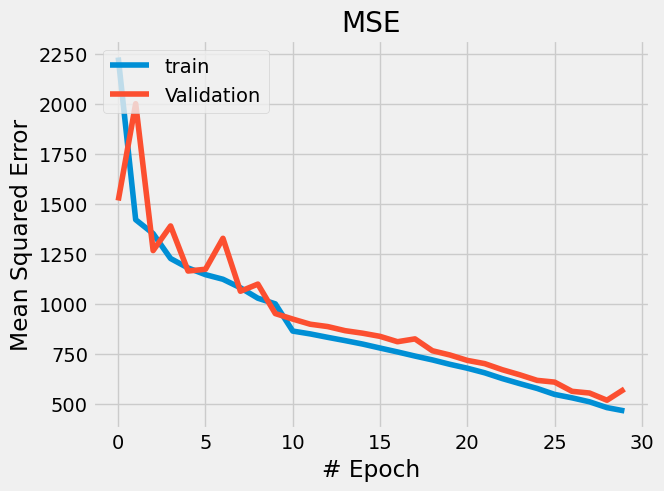

In [74]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('MSE')
plt.ylabel('Mean Squared Error')
plt.xlabel('# Epoch')
plt.legend(['train', 'Validation'], loc='upper left')
plt.show()

Why did we run the model only for 20 epochs, even though the validation loss seems to be decreasing? Well, while training this model for more epochs, we previously observed that it is possible to decrease the validation loss to a very small number. But in that case, our actual test loss is not that great. This is because our model is overfitting the validation dataset. So to get a good test performance, we should stop our training at an intermediate value of the validation loss. We chose 20 epochs as that gives a good enough test error.

### Results on Train Set

In [75]:
scores = model.evaluate(x_train, y_train, verbose=1, batch_size=200)
print('MSE: {}'.format(scores))

89/89 [==============================] - 1s 6ms/step - loss: 511.8847
MSE: 511.8846740722656


### Results on Test Set

In [76]:
scores_test = model.evaluate(x_test, y_test, verbose=2)
print('MSE: {}'.format(scores_test))

4/4 - 0s - loss: 1876.6317
MSE: 1876.6317138671875


2022-10-25 11:22:39.593509: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


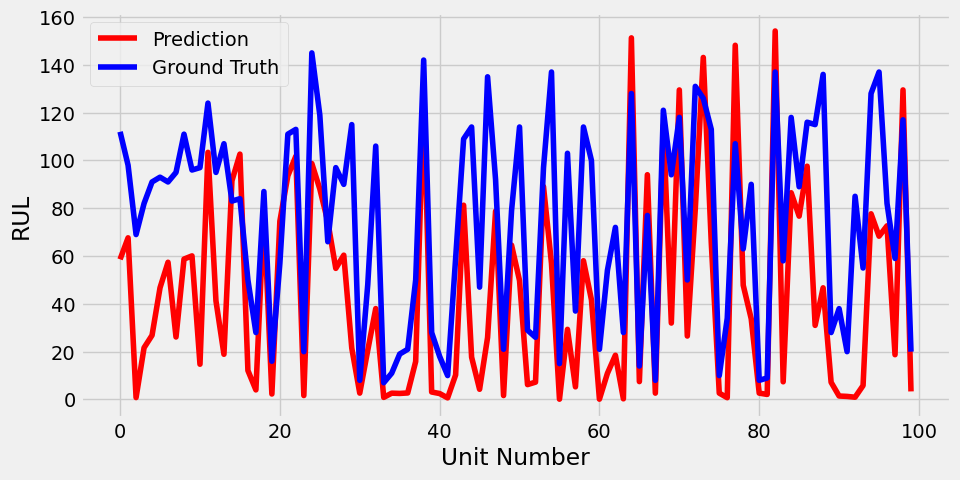

In [77]:
y_pred_test = model.predict(x_test, verbose=0)
plt.figure(figsize=(10,5))
plt.plot(y_pred_test, color='red', label='Prediction')
plt.plot(y_test, color='blue', label='Ground Truth')
plt.ylabel("RUL")
plt.xlabel("Unit Number")
plt.legend(loc='upper left')
plt.show()

S-score:  98767822.27992207


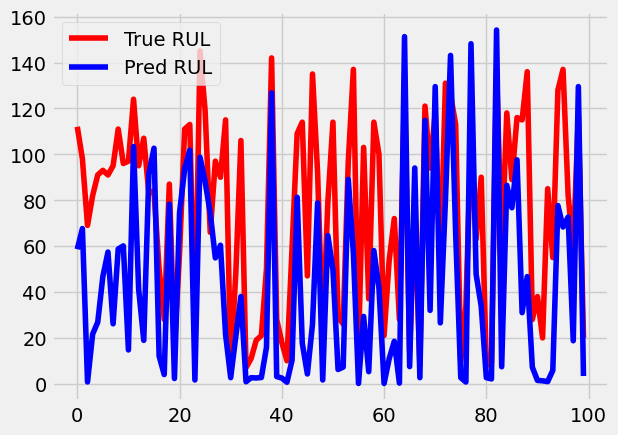

In [78]:
def compute_s_score(rul_true, rul_pred):
    """
    Both rul_true and rul_pred should be 1D numpy arrays.
    """
    diff = rul_pred - rul_true
    return np.sum(np.where(diff < 0, np.exp(-diff/13)-1, np.exp(diff/10)-1))
    
s_score = compute_s_score(y_test, y_pred_test)
print("S-score: ", s_score)
# Plot true and predicted RUL values
plt.plot(y_test, label = "True RUL", color = "blue")
plt.plot(y_pred_test, label = "Pred RUL", color = "red")
plt.legend()
plt.show()